In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "Potato",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE

)

Found 2152 files belonging to 3 classes.


In [4]:
class_names= dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
68*32

2176

In [7]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 0 0 0 2 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 1 0]


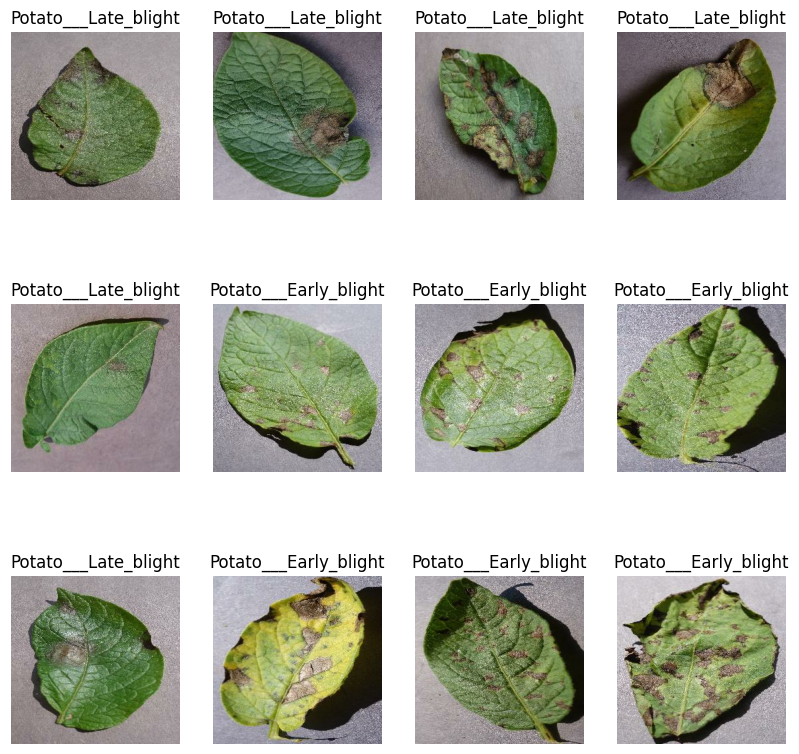

In [8]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

80% ==>training
20% ==>10% validation, 10% test

In [9]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split * ds_size)
    val_size =int(val_split * ds_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    
    return train_ds,test_ds,val_ds

In [10]:
train_ds,test_ds,val_ds=get_dataset_partitions_tf(dataset)

In [11]:
print(len(train_ds),len(test_ds),len(val_ds))

54 8 6


In [12]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
input_shape=(BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE,CHANNELS)
n_classes=3
model= models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'softmax'),
    
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history=model.fit(
    train_ds, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 101s 2s/step - loss: 1.2857 - accuracy: 0.4630 - val_loss: 0.8797 - val_accuracy: 0.5573
Epoch 2/50
54/54 [==============================] - 91s 2s/step - loss: 0.7529 - accuracy: 0.6435 - val_loss: 0.8990 - val_accuracy: 0.5729
Epoch 3/50
54/54 [==============================] - 96s 2s/step - loss: 0.4986 - accuracy: 0.7917 - val_loss: 0.4777 - val_accuracy: 0.8073
Epoch 4/50
54/54 [==============================] - 94s 2s/step - loss: 0.3268 - accuracy: 0.8692 - val_loss: 0.3075 - val_accuracy: 0.8698
Epoch 5/50
54/54 [==============================] - 87s 2s/step - loss: 0.2585 - accuracy: 0.8976 - val_loss: 0.3555 - val_accuracy: 0.8750
Epoch 6/50
54/54 [==============================] - 86s 2s/step - loss: 0.2171 - accuracy: 0.9259 - val_loss: 0.2583 - val_accuracy: 0.8958
Epoch 7/50
54/54 [==============================] - 86s 2s/step - loss: 0.2000 - accuracy: 0.9132 - val_loss: 0.2332 - val_accuracy: 0.9323
Epoch 8/50
54/54 [=

In [19]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 4s 264ms/step - loss: 0.1084 - accuracy: 0.9609


In [20]:
scores

[0.10842718183994293, 0.9609375]

In [21]:
history

In [22]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

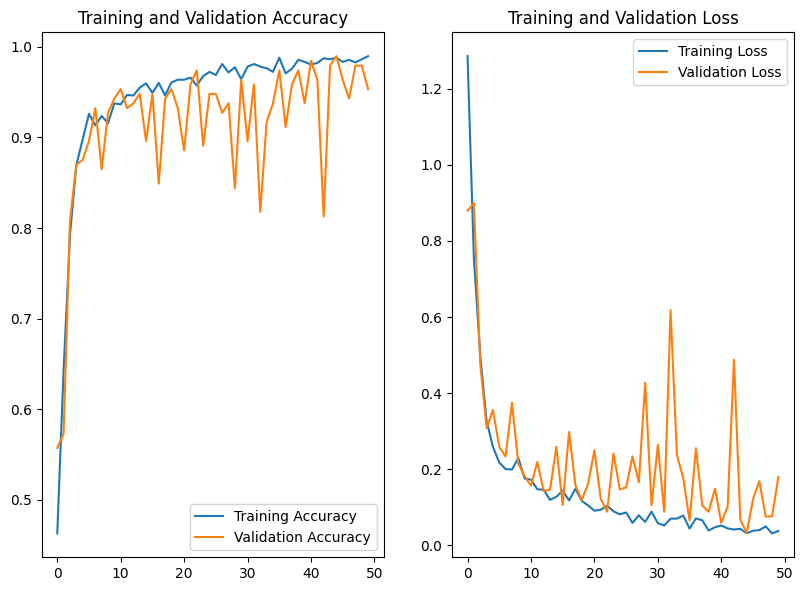

In [25]:
plt.figure(figsize = (15,15))
plt.subplot(2,3,1)
plt.plot(range(EPOCHS), train_acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy') 

plt.subplot(2,3,2)
plt.plot(range(EPOCHS), train_loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

First Image of batch to predict :
Actual label :  Potato___Late_blight
1/1 [==============================] - 1s 501ms/step
Predicted label :  Potato___Late_blight


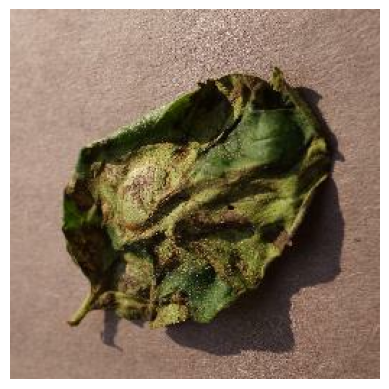

In [26]:
import numpy as np
for batch_image, batch_label in train_ds.take(1):
    first_image = batch_image[0].numpy().astype('uint8')
    first_label = class_names[batch_label[0]]
    
    print('First Image of batch to predict :')
    plt.imshow(first_image)
    print('Actual label : ', first_label)
    
    batch_prediction = model.predict(batch_image)
    print('Predicted label : ', class_names[np.argmax(batch_prediction[0])])
    plt.axis('off')

1/1 [==============================] - 0s 266ms/step


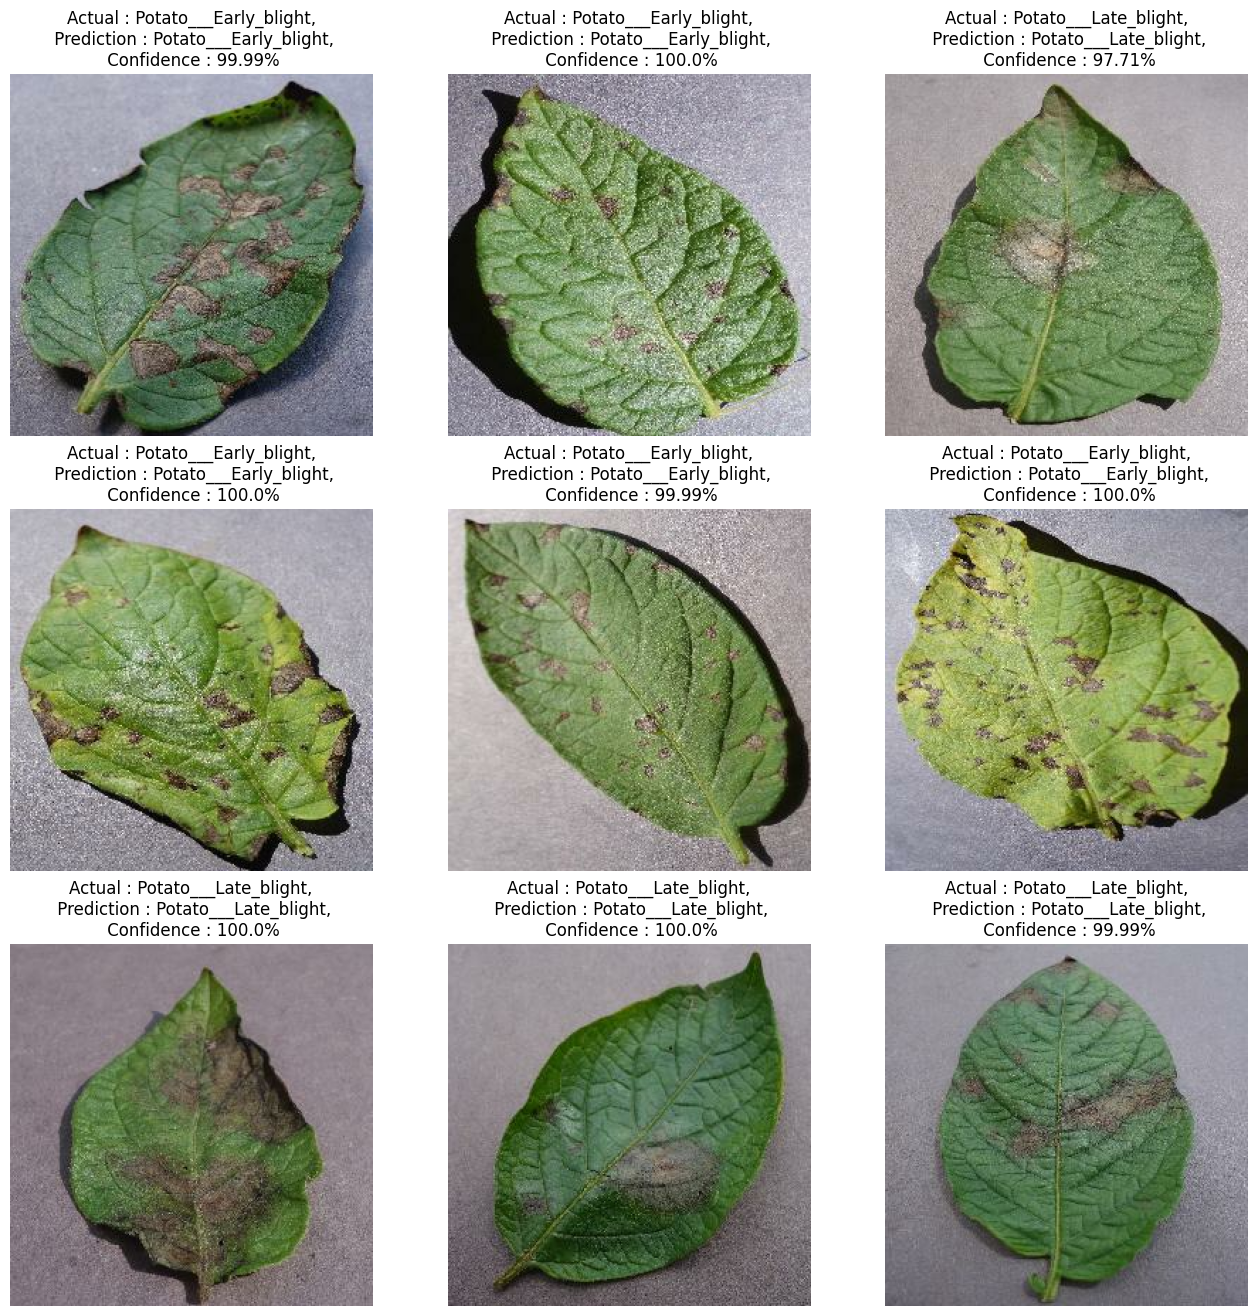

In [27]:
plt.figure(figsize = (16,16))
for batch_image, batch_label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        image = batch_image[i].numpy().astype('uint8')
        label = class_names[batch_label[i]]
    
        plt.imshow(image)
    
        batch_prediction = model.predict(batch_image)
        predicted_class = class_names[np.argmax(batch_prediction[i])]
        confidence = round(np.max(batch_prediction[i]) * 100, 2)
        
        plt.title(f'Actual : {label},\n Prediction : {predicted_class},\n Confidence : {confidence}%')
    
        plt.axis('off')

In [29]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models")+[0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/3\assets


INFO:tensorflow:Assets written to: ../saved_models/3\assets


First Image of batch to predict :
Actual label :  Potato___Late_blight
1/1 [==============================] - 0s 332ms/step
Predicted label :  Potato___Late_blight


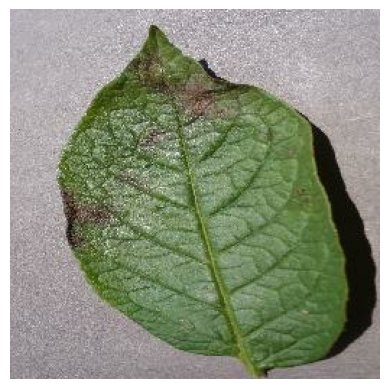

In [30]:
import numpy as np
for batch_image, batch_label in train_ds.take(1):
    first_image = batch_image[0].numpy().astype('uint8')
    first_label = class_names[batch_label[0]]
    
    print('First Image of batch to predict :')
    plt.imshow(first_image)
    print('Actual label : ', first_label)
    
    batch_prediction = model.predict(batch_image)
    print('Predicted label : ', class_names[np.argmax(batch_prediction[0])])
    plt.axis('off')
    

In [31]:
import tensorflow as tf
import numpy as np

model = tf.saved_model.load('C:/subsea/Potato_Leaf_disease_detection/saved_models/1')

image_path = "C:/subsea/Potato_Leaf_disease_detection/Demo/2e.jpeg"
image = tf.io.read_file(image_path)
image = tf.image.decode_image(image, channels=3)
image = tf.image.resize(image, (256, 256))
image = tf.image.convert_image_dtype(image, tf.float32)
image = tf.expand_dims(image, axis=0)  

predictions = model(image)
predicted_label = tf.argmax(predictions, axis=1)

class_labels = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']  

predicted_class = class_labels[predicted_label[0].numpy()]
predicted_class

'Potato___Early_blight'